<a href="https://colab.research.google.com/github/SamudralaAjaykumarrr/openai-prompt-regression/blob/main/OpenAI_Prompt_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

print("All libraries imported successfully ✅")


All libraries imported successfully ✅


In [ ]:
# Cell 2 — Create synthetic dataset (deterministic)
import numpy as np, pandas as pd
np.random.seed(42)

N = 800                 # small, fast, representative
data = pd.DataFrame({
    "prompt_length": np.random.randint(5, 120, N),               # tokens
    "num_keywords": np.random.randint(0, 12, N),                 # keyword count
    "temperature": np.round(np.random.uniform(0.05, 1.0, N),3),  # sampling temp
    "response_length": np.random.randint(10, 400, N),            # tokens
    "avg_word_complexity": np.round(np.random.uniform(1.0, 3.0, N),3)  # proxy
})

# Realistic synthetic target (performance_score 0-100)
# linear combination + nonlinear term + gaussian noise
data["performance_score"] = (
      40
    + 0.25 * data["prompt_length"]
    + 1.8 * data["num_keywords"]
    - 30  * data["temperature"]
    + 0.12 * data["response_length"]
    - 2.5  * (data["avg_word_complexity"] - 1.5)**2
    + np.random.normal(0, 4.0, N)
)

# clamp to 0-100 for realism
data["performance_score"] = data["performance_score"].clip(0, 100).round(3)

print("Dataset created:", data.shape)
display(data.head(8))
print("\nTarget stats:")
print(data["performance_score"].describe().round(3))


Dataset created: (800, 6)


,prompt_length,num_keywords,temperature,response_length,avg_word_complexity,performance_score
0,107,9,0.563,129,2.015,75.708
1,56,9,0.204,138,2.748,79.505
2,97,2,0.849,139,1.987,56.455
3,19,6,0.854,69,2.405,37.216
4,111,2,0.957,57,2.986,45.136
5,76,1,0.197,38,1.263,58.372
6,65,11,0.642,106,1.549,66.369
7,25,9,0.501,19,1.789,46.729



Target stats:
count    800.000
mean      71.711
std       18.235
min       22.789
25%       58.852
50%       72.565
75%       86.436
max      100.000
Name: performance_score, dtype: float64


In [ ]:
# Cell 3 — train/test split, regression, metrics
X = data[["prompt_length","num_keywords","temperature","response_length","avg_word_complexity"]]
y = data["performance_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # safe for all versions
r2   = r2_score(y_test, y_pred)

print("Model metrics:")
print(f" MAE : {mae:.3f}")
print(f" RMSE: {rmse:.3f}")
print(f" R2  : {r2:.3f}")


Model metrics:
 MAE : 3.326
 RMSE: 4.332
 R2  : 0.952


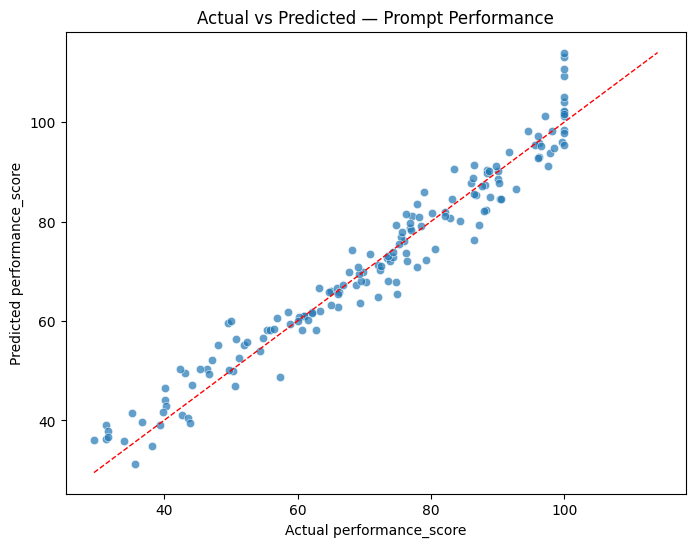

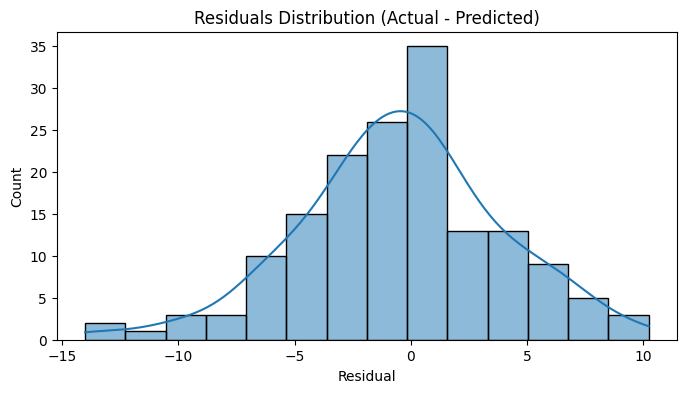

In [ ]:
# Cell 4 — visuals
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel("Actual performance_score")
plt.ylabel("Predicted performance_score")
plt.title("Actual vs Predicted — Prompt Performance")
plt.show()

# Residuals distribution
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.show()


In [ ]:
# Cell 5 — coefficients as feature importance and save model + dataset + results
import pandas as pd
import joblib
import json
import os

FEATURES = ["prompt_length","num_keywords","temperature","response_length","avg_word_complexity"]
TARGET = "performance_score"

# Ensure metrics are computed before saving
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)  # in case previous cell failed
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

metrics = {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

# Feature coefficients
coeffs = pd.DataFrame({
    "feature": FEATURES,
    "coefficient": model.coef_
}).sort_values(by="coefficient", ascending=False)

print("Feature coefficients (sorted):")
display(coeffs.style.format({"coefficient":"{:.4f}"}))

# Save model and files to workspace for download + GitHub upload
os.makedirs("/content/ai_prompt_regression_outputs", exist_ok=True)
joblib.dump(model, "/content/ai_prompt_regression_outputs/openai_prompt_regression_model.pkl")
data.to_csv("/content/ai_prompt_regression_outputs/prompt_regression_dataset.csv", index=False)
with open("/content/ai_prompt_regression_outputs/metrics.json","w") as f:
    json.dump(metrics, f, indent=2)

print("\nSaved to /content/ai_prompt_regression_outputs/")
!ls -la /content/ai_prompt_regression_outputs


Feature coefficients (sorted):


,feature,coefficient
1,num_keywords,1.5495
0,prompt_length,0.2227
3,response_length,0.1132
4,avg_word_complexity,-2.1450
2,temperature,-26.6835



Saved to /content/ai_prompt_regression_outputs/
total 40
drwxr-xr-x 2 root root  4096 Nov 13 13:18 .
drwxr-xr-x 1 root root  4096 Nov 13 13:18 ..
-rw-r--r-- 1 root root    88 Nov 13 13:19 metrics.json
-rw-r--r-- 1 root root   945 Nov 13 13:19 openai_prompt_regression_model.pkl
-rw-r--r-- 1 root root 22232 Nov 13 13:19 prompt_regression_dataset.csv


In [ ]:
# Cell 6 — README + short report
readme = f"""# OpenAI Prompt Regression — AI Prompt Performance Analysis

**What**: Synthetic prompt dataset + regression to predict prompt performance (0–100).
**Why**: Demonstrates ability to engineer features, train and evaluate models, and produce reproducible artifacts for recruiters/interviewers.

**Files**
- `openai_prompt_regression_model.pkl` — trained LinearRegression model (joblib).
- `prompt_regression_dataset.csv` — synthetic dataset used for train/test.
- `metrics.json` — performance metrics (MAE, RMSE, R2).
- `README.md` — this file.

**How to run**
1. Download files from the Colab `ai_prompt_regression_outputs` folder.
2. Use Python and joblib to load the model and reproduce predictions.

**Key results**
- MAE: {metrics['MAE']:.3f}
- RMSE: {metrics['RMSE']:.3f}
- R²: {metrics['R2']:.3f}

**Skills demonstrated**
- Python, pandas, numpy, scikit-learn
- Regression modeling, evaluation metrics (MAE/RMSE/R²)
- Data visualization and reproducible outputs
"""

with open("/content/ai_prompt_regression_outputs/README.md", "w") as f:
    f.write(readme)

print("README and report saved to /content/ai_prompt_regression_outputs/README.md")
print("\nFinal files:")
!ls -la /content/ai_prompt_regression_outputs


README and report saved to /content/ai_prompt_regression_outputs/README.md

Final files:
total 44
drwxr-xr-x 2 root root  4096 Nov 13 13:20 .
drwxr-xr-x 1 root root  4096 Nov 13 13:18 ..
-rw-r--r-- 1 root root    88 Nov 13 13:19 metrics.json
-rw-r--r-- 1 root root   945 Nov 13 13:19 openai_prompt_regression_model.pkl
-rw-r--r-- 1 root root 22232 Nov 13 13:19 prompt_regression_dataset.csv
-rw-r--r-- 1 root root   937 Nov 13 13:20 README.md
